In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scanpy as sc
import re
import decoupler as dc
import sc_toolbox
import random
import seaborn.objects as so

In [2]:
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/"
newdata_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"

sys.path = sys.path + ["/well/immune-rep/users/vbw431/python_utils/"]

In [3]:
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from rpy2.ipython.ggplot import image_png

#sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/well/immune-rep/users/vbw431/conda/ivybridge/envs/scverse_new/lib/python3.8/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.2
  warnings.warn(


In [4]:
%%R
.libPaths(c(paste0("/well/immune-rep/users/vbw431/conda/ivybridge/envs/scverse_new/r_modules"), .libPaths()))

library(tidyverse)
library(Seurat)
library(SCPA)

cur.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/DIMITRA_FASTQ/"
work.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/"
out.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/out/"
references = "/well/immune-rep/users/vbw431/reference/reference/refdata-gex-GRCh38-2020-A/"
com.out = "/well/immune-rep/users/vbw431/Projects/Peppa/reference_combat/"

##plotting
library(ggplot2); theme_set(theme_bw(base_size = 18)+
                              theme(strip.text = element_text(colour = 'black', face="bold",size=12), 
                                    panel.grid.major = element_blank(), 
                                    panel.grid.minor = element_blank(),
                                    panel.border = element_rect(size = 0.7),
                                    axis.ticks.length=unit(.10, "cm"),
                                    axis.ticks = element_line(size=0.7),
                                    strip.background = element_blank()))



-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x purrr::%@%()                 masks rlang::%@%()
x lazyeval::as_name()          masks rlang::as_name()
x lazyeval::call_modify()      masks rlang::call_modify()
x lazyeval::call_standardise() masks rlang::call_standardise()
x lazyeval::expr_label()       masks rlang::expr_label()
x lazyeval::expr_text()        masks rlang::expr_text()
x lazyeval::f_env()            masks rlang::f_env()
x lazyeval::f_env<-()          masks rlang::f_env<-()
x lazyeval::f_label()          masks rlang::f_label()
x lazyeval::f_lhs()            masks rlang::f_lhs()
x lazyeval::f_lhs<-()          masks rlang::f_lhs<-()
x lazyeval::f_rhs()            masks rlang::f_rhs()
x lazyeval::f_rhs<-() 

In [5]:
%%R
scpa_out <- readRDS(paste0(out.dir, "/scpa_subset.rds"))

In [6]:
%%R
scpa_out[[1]] %>% head()

                                                                                                                         Pathway
1                                                                                                           GOBP_CELL_CHEMOTAXIS
2                                                                                             GOBP_DEFENSE_RESPONSE_TO_BACTERIUM
3                                                                                 GOBP_POSITIVE_REGULATION_OF_HYDROLASE_ACTIVITY
4                                                                                                KEGG_AUTOIMMUNE_THYROID_DISEASE
5                                                                                    REACTOME_CLASS_A_1_RHODOPSIN_LIKE_RECEPTORS
6 GOBP_ADAPTIVE_IMMUNE_RESPONSE_BASED_ON_SOMATIC_RECOMBINATION_OF_IMMUNE_RECEPTORS_BUILT_FROM_IMMUNOGLOBULIN_SUPERFAMILY_DOMAINS
          Pval      adjPval     qval          FC
1 1.881730e-22 9.696553e-19 4.244218  1.23577023

In [7]:
%%R

plotlist <- lapply(names(scpa_out), function(x){
    tmp <- scpa_out[[paste0(x)]] %>%
      mutate(color = case_when(FC > 5 & adjPval < 0.01 ~ '#6dbf88',
                               FC < 5 & FC > -5 & adjPval < 0.01 ~ '#84b0f0',
                               FC < -5 & adjPval < 0.01 ~ 'mediumseagreen',
                               FC < 5 & FC > -5 & adjPval > 0.01 ~ 'black'))

    highlight <- tmp %>% 
      filter(grepl(pattern = "TCR|ZAP", ignore.case = T, x = Pathway))

    plot<- ggplot(tmp, aes(-FC, qval)) +
      geom_vline(xintercept = c(-5, 5), linetype = "dashed", col = 'black', lwd = 0.3) +
      geom_point(cex = 2.6, shape = 21, fill = tmp$color, stroke = 0.3) +
      geom_point(data = highlight, shape = 21, cex = 2.8, fill = "orangered2", color = "black", stroke = 0.3) +
      xlab("Enrichment") +
      ylab("Qval") +
      theme(panel.background = element_blank(),
            panel.border = element_rect(fill = NA),
            aspect.ratio = 1)+
    ggtitle(x)
    return(plot)
})


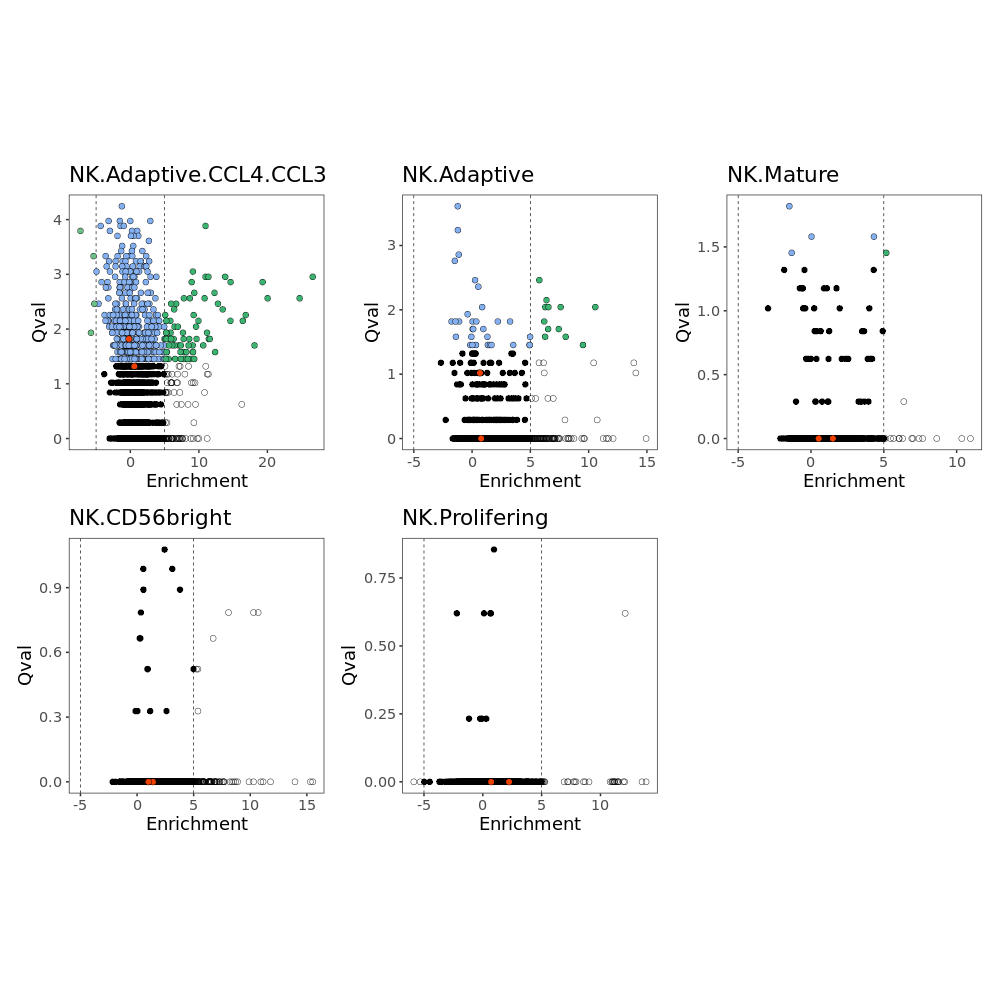

In [8]:
%%R -h 1000 -w 1000
patchwork::wrap_plots(plotlist)

In [9]:
%%R
library(ComplexHeatmap)
library(magrittr)

tmp <- lapply(names(scpa_out), function(x){
        tmp <-scpa_out[[paste0(x)]] %>% 
            dplyr::select(Pathway, qval) %>%
            ##remove Kegg pathways - too many autoimmune disease pathways which are not informative
            filter(!grepl("KEGG", Pathway)) %>%
            set_colnames(c("Pathway", paste(x, "qval", sep = "_"))) 
    return(tmp)
})

names(tmp) <- names(scpa_out)

tmp<- tmp  %>%
  reduce(full_join, by = "Pathway") %>% 
  set_colnames(gsub(colnames(.), pattern = " ", replacement = "_")) %>%
  select(c("Pathway", grep("_qval", colnames(.)))) %>%
  filter_all(any_vars(. > 2)) %>%
  column_to_rownames("Pathway")



In [10]:
%%R
##remove pathways with no change
tmp <- tmp[rowSums(tmp[])>0,]


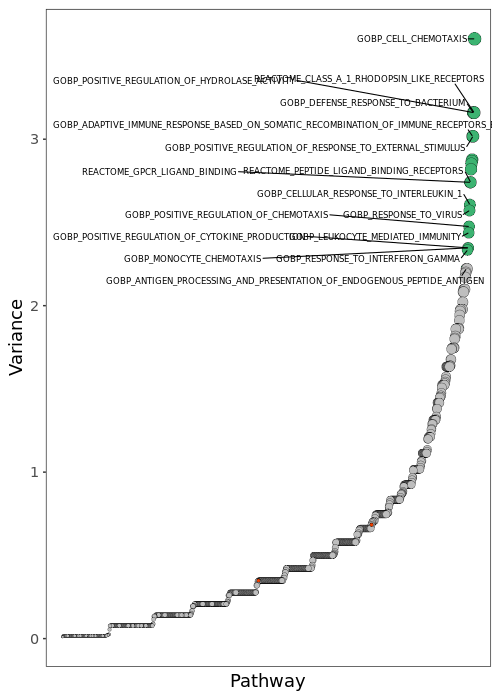

In [11]:
%%R -h 700 -w 500
##extract most pathways of most variance across cell subsets *NB, not necessarily the most significant
variance <- apply(tmp, 1, var) %>%
    data.frame() %>% 
    set_colnames("variance") %>%
    arrange(desc(variance)) %>% 
    rownames_to_column("pathway")

toppathways <- head(variance$pathway, 20)
variance$label <- ifelse(variance$pathway == toppathways, variance$pathway, NA)

variance <- variance %>%
    mutate(color = ifelse(!is.na(label), "mediumseagreen", "gray"))

highlight <- variance %>% 
      filter(grepl(pattern = "TCR|ZAP", ignore.case = T, x = pathway))


ggplot(variance, aes(reorder(pathway, variance), variance)) +
  geom_point(aes(fill = color, size=variance),shape = 21, color = 'black', stroke = 0.2) +
    geom_point(data = highlight, shape = 21, fill = "orangered2", color = "black", stroke = 0.3) +
  scale_x_discrete(expand = c(0.04, 0.04)) +
  labs(x = "Pathway", y = "Variance") +
    ggrepel::geom_text_repel(aes(label= label),size=3, min.segment.length = 0,seed = 42, force = 3, box.padding = 0.5, max.overlaps = 6)+
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(fill = NA),
       legend.position="none")+
    scale_fill_manual(values = c("gray", "mediumseagreen"))



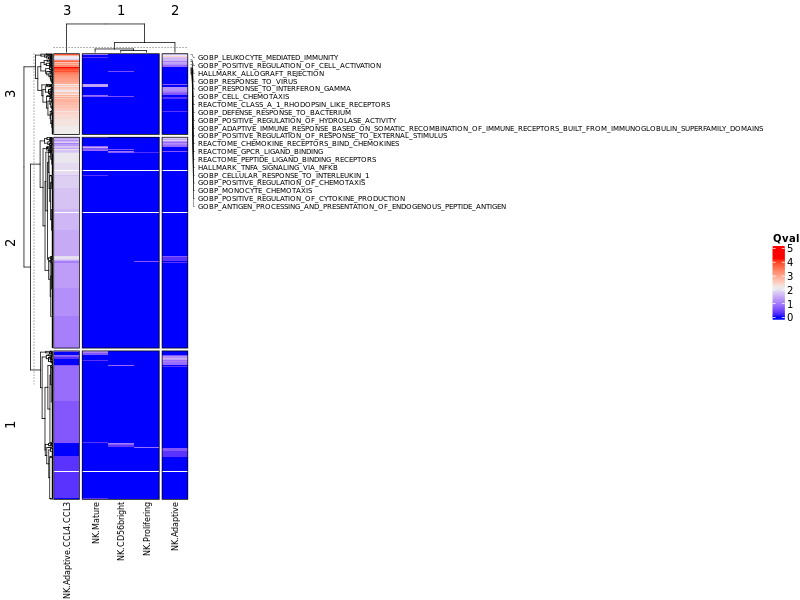

In [12]:
%%R -h 600 -w 800

position <- which(rownames(tmp) %in% toppathways)
row_an <- rowAnnotation(Genes = anno_mark(at = which(rownames(tmp) %in% toppathways),
                                          labels = rownames(tmp)[position],
                                          labels_gp = gpar(fontsize = 7),
                                          link_width = unit(2.5, "mm"),
                                          padding = unit(1, "mm"),
                                          link_gp = gpar(lwd = 0.5)))

Heatmap(tmp,
        name = "Qval",
        show_row_names = F,
        right_annotation = row_an,
        column_names_gp = gpar(fontsize = 8),
        border = T,
        column_km = 3,
        row_km = 3,
        column_labels = names(scpa_out))

In [13]:
%%R

scpa_tmp <- lapply(names(scpa_out), function(x){
    tmp <- scpa_out[[paste0(x)]] %>% 
    mutate(cell_subset = x)
    return(tmp)
})


In [14]:
%%R
scpa_combined <- data.table::rbindlist(scpa_tmp)


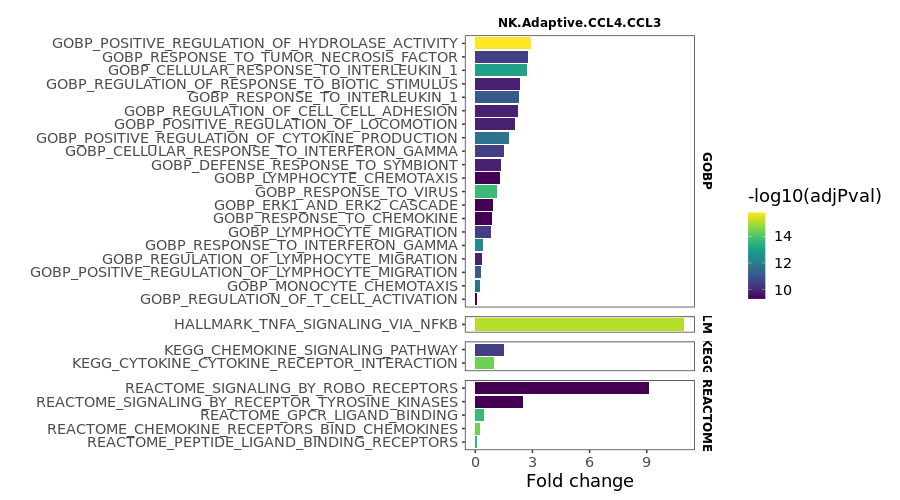

In [15]:
%%R -h 500 -w 900
scpa_combined %>%
filter(adjPval <0.05) %>%
filter(qval >3) %>%
filter(-FC >=0) %>%
#filter(Pathway %in% toppathways) %>%
mutate(database = gsub("_.*", "", Pathway)) %>%
#filter(grepl("GOBP", Pathway)) %>%
#filter(grepl("NK", cell_subset)) %>%
ggplot(aes(-FC, reorder(Pathway, -FC))) +
geom_col(aes(fill=-log10(adjPval)))+
facet_grid(vars(database), vars(cell_subset), scales="free_y", space="free")+
viridis::scale_fill_viridis()+
ylab("")+
xlab("Fold change")